In [1]:
#NOTE: use python env acmil in ACMIL folder
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.optim as optim
from pathlib import Path
import PIL
from skimage import filters
import random

    
sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize, set_seed
from Utils import log_message
from Eval import compute_performance, plot_LOSS, compute_performance_each_label, get_attention_and_tileinfo, get_performance
from train_utils import pull_tiles, FocalLoss
from train_utils import ModelReadyData_diffdim, convert_to_dict, prediction_sepatt, BCE_Weighted_Reg, BCE_Weighted_Reg_focal, compute_loss_for_all_labels_sepatt
from Model import Mutation_MIL_MT_sepAtt #, Mutation_MIL_MT
from ACMIL import ACMIL_GA_MultiTask, predict, train_one_epoch_multitask, evaluate_multitask
warnings.filterwarnings("ignore")
%matplotlib inline


#FOR ACMIL
current_dir = os.getcwd()
grandparent_subfolder = os.path.join(current_dir, '..', '..', 'other_model_code','ACMIL-main')
grandparent_subfolder = os.path.normpath(grandparent_subfolder)
sys.path.insert(0, grandparent_subfolder)
from utils.utils import save_model, Struct, set_seed
import yaml
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import yaml
from pprint import pprint

import argparse
import torch
from torch.utils.data import DataLoader

from utils.utils import save_model, Struct, set_seed
from datasets.datasets import build_HDF5_feat_dataset
from architecture.transformer import ACMIL_GA #ACMIL_GA
from architecture.transformer import ACMIL_MHA
import torch.nn.functional as F
import wandb

In [2]:
####################################
######      USERINPUT       ########
####################################
ALL_LABELS = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
TUMOR_FRAC_THRES = 0.9 
feature_extraction_method = 'uni2' #retccl, uni1
learning_method = "acmil"
focal_gamma = 20
focal_alpha = 0.95
loss_method = 'Focal' #ATTLOSS

################################
#model Para
BATCH_SIZE  = 1
DROPOUT = 0
DIM_OUT = 128
SELECTED_MUTATION = "MT"
SELECTED_FOLD = 0
arch = 'ga_mt' #ga_mt or ga

if feature_extraction_method == 'retccl':
    SELECTED_FEATURE = [str(i) for i in range(0,2048)] + ['TUMOR_PIXEL_PERC'] #If retccl 2048, if uni 1024
    N_FEATURE = 2048
elif feature_extraction_method == 'uni1': 
    SELECTED_FEATURE = [str(i) for i in range(0,1024)] + ['TUMOR_PIXEL_PERC'] #If retccl 2048, if uni 1024
    N_FEATURE = 1024
elif feature_extraction_method == 'uni2':
    SELECTED_FEATURE = [str(i) for i in range(0,1536)] + ['TUMOR_PIXEL_PERC'] #If retccl 2048, if uni 1024
    N_FEATURE = 1536
    
################################
# get config
config_dir = "myconf.yml"
with open(config_dir, "r") as ymlfile:
    c = yaml.load(ymlfile, Loader=yaml.FullLoader)
    #c.update(vars(args))
    conf = Struct(**c)

conf.train_epoch = 200
conf.D_feat = N_FEATURE
conf.D_inner = DIM_OUT
conf.n_token = 3
conf.n_class = 1
conf.wandb_mode = 'disabled'
conf.mask_drop = 0.6
conf.n_masked_patch = 0
conf.n_task = 7
#conf.lr = 0.000001 #change this for HR only

# Print all key-value pairs in the conf object
for key, value in conf.__dict__.items():
    print(f"{key}: {value}")
    
##################
###### DIR  ######
##################
proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/'
folder_name_overlap = "IMSIZE250_OL100"
folder_name_nonoverlap = "IMSIZE250_OL0"
feature_path_opx_train =  os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "OPX", folder_name_overlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))
feature_path_opx_test =  os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "OPX", folder_name_nonoverlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))
feature_path_tma = os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "TAN_TMA_Cores",folder_name_nonoverlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))
feature_path_tcga = os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "TCGA_PRAD",folder_name_nonoverlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))

folder_name_ids = 'uni1/TrainOL100_TestOL0_TFT' + str(TUMOR_FRAC_THRES)  + "/"
train_val_test_id_path =  os.path.join(proj_dir + 'intermediate_data/6_Train_TEST_IDS', folder_name_ids)

train_epoch: 200
warmup_epoch: 0
wd: 1e-05
lr: 0.0001
min_lr: 0
dataset: bracs
B: 1
n_class: 1
n_worker: 8
pin_memory: False
n_shot: -1
D_feat: 1536
D_inner: 128
n_token: 3
wandb_mode: disabled
mask_drop: 0.6
n_masked_patch: 0
n_task: 7


In [3]:
######################
#Create output-dir
################################################
folder_name1 = feature_extraction_method + '/TrainOL100_TestOL0_TFT' + str(TUMOR_FRAC_THRES)  + "/"
outdir0 =  proj_dir + "intermediate_data/pred_out02282025" + "/" + folder_name1 + 'FOLD' + str(SELECTED_FOLD) + '/' + SELECTED_MUTATION + "/" 
outdir1 =  outdir0  + "/saved_model/"
outdir2 =  outdir0  + "/model_para/"
outdir3 =  outdir0  + "/logs/"
outdir4 =  outdir0  + "/predictions/"
outdir5 =  outdir0  + "/perf/"


create_dir_if_not_exists(outdir0)
create_dir_if_not_exists(outdir1)
create_dir_if_not_exists(outdir2)
create_dir_if_not_exists(outdir3)
create_dir_if_not_exists(outdir4)
create_dir_if_not_exists(outdir5)

##################
#Select GPU
##################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//saved_model/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//model_para/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//logs/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//predictions/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//perf/' already exists.
cuda:0


In [4]:
################################################
#     Model ready data 
################################################
opx_data_ol100 = torch.load(feature_path_opx_train + '/OPX_data.pth')
opx_ids_ol100 = torch.load(feature_path_opx_train + '/OPX_ids.pth')
opx_info_ol100  = torch.load(feature_path_opx_train + '/OPX_info.pth')

opx_data_ol0 = torch.load(feature_path_opx_test + '/OPX_data.pth')
opx_ids_ol0 = torch.load(feature_path_opx_test + '/OPX_ids.pth')
opx_info_ol0  = torch.load(feature_path_opx_test + '/OPX_info.pth')

tma_data = torch.load(feature_path_tma + '/tma_data.pth')
tma_ids = torch.load(feature_path_tma + '/tma_ids.pth')
tma_info  = torch.load(feature_path_tma + '/tma_info.pth')


tcga_data = torch.load(feature_path_tcga + '/TCGA_data.pth')
tcga_ids = torch.load(feature_path_tcga + '/TCGA_ids.pth')
tcga_info  = torch.load(feature_path_tcga + '/TCGA_info.pth')

In [5]:
########################################################
#Update tma
########################################################
haslabel_indexes = []
for i in range(len(tma_data)):
    if torch.isnan(tma_data[i][1]).all() == False:
        #print(f"Item {i} has the second element all NaNs.")
        haslabel_indexes.append(i)


tma_data = Subset(tma_data, haslabel_indexes)
tma_ids = list(Subset(tma_ids, haslabel_indexes))
tma_info = list(Subset(tma_info, haslabel_indexes))
len(tma_info) #355 if TF0.9, a lot of cores does not have enough cancer tiles > 0.9

355

In [6]:
################################################
#Get train, test IDs
#NOTE: this was in the old train: ['OPX_207','OPX_209','OPX_213','OPX_214','OPX_215']
################################################
train_test_val_id_df = pd.read_csv(train_val_test_id_path + "train_test_split.csv")
train_ids_all = list(train_test_val_id_df.loc[train_test_val_id_df['FOLD' + str(SELECTED_FOLD)] == 'TRAIN', 'SAMPLE_ID'])
test_ids_all = list(train_test_val_id_df.loc[train_test_val_id_df['FOLD' + str(SELECTED_FOLD)] == 'TEST', 'SAMPLE_ID'])
val_ids_all = list(train_test_val_id_df.loc[train_test_val_id_df['FOLD' + str(SELECTED_FOLD)] == 'VALID', 'SAMPLE_ID'])

In [7]:
################################################
#Get Train, test, val data
################################################
#Train:
inc_idx = [opx_ids_ol100.index(x) for x in train_ids_all]
train_data = Subset(opx_data_ol100, inc_idx)
train_ids =  list(Subset(opx_ids_ol100, inc_idx))
train_info = list(Subset(opx_info_ol100, inc_idx))

#Val:
inc_idx = [opx_ids_ol100.index(x) for x in val_ids_all]
val_data = Subset(opx_data_ol100, inc_idx)
val_ids =  list(Subset(opx_ids_ol100, inc_idx))
val_info = list(Subset(opx_info_ol100, inc_idx))

#Test:
inc_idx = [opx_ids_ol0.index(x) for x in test_ids_all]
test_data = Subset(opx_data_ol0, inc_idx)
test_ids =  list(Subset(opx_ids_ol0, inc_idx))
test_info = list(Subset(opx_info_ol0, inc_idx))

In [8]:
#count labels in train
train_label_counts = [dt[1] for dt in train_data]
train_label_counts = torch.concat(train_label_counts)
count_ones = (train_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/train_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers)

#count labels in test
test_label_counts = [dt[1] for dt in test_data]
test_label_counts = torch.concat(test_label_counts)
count_ones = (test_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/test_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers)

#count labels in tma
tma_label_counts = [dt[1] for dt in tma_data] 
tma_label_counts = torch.concat(tma_label_counts)
count_ones = (tma_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/tma_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers) #["AR","PTEN","RB1","TP53"


#count labels in tcga
tcga_label_counts = [dt[1] for dt in tcga_data] 
tcga_label_counts = torch.concat(tcga_label_counts)
count_ones = (tcga_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/tcga_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers) #["AR","PTEN","RB1","TP53"

tensor([15, 25, 32, 18, 55, 10,  9])
['10.0', '16.7', '21.3', '12.0', '36.7', '6.7', '6.0']
tensor([ 5,  7,  8,  4, 18,  7,  7])
['11.1', '15.6', '17.8', '8.9', '40.0', '15.6', '15.6']
tensor([216,   0, 119, 107, 178,   0,   0])
['60.8', '0.0', '33.5', '30.1', '50.1', '0.0', '0.0']
tensor([ 2, 34, 13,  3, 53,  0,  4])
['0.4', '7.6', '2.9', '0.7', '11.9', '0.0', '0.9']


In [9]:
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(tma_data))
print(len(tcga_data))

150
8
45
355
447


In [10]:
####################################################
#            Train 
####################################################
set_seed(0)
#Dataloader for training
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)
tma_loader = DataLoader(dataset=tma_data, batch_size=BATCH_SIZE, shuffle=False)
tcga_loader = DataLoader(dataset=tcga_data, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# define network
if arch == 'ga':
    model = ACMIL_GA(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop= conf.mask_drop)
elif arch == 'ga_mt':
    model = ACMIL_GA_MultiTask(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop= conf.mask_drop, n_task = conf.n_task)
else:
    model = ACMIL_MHA(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop=conf.mask_drop)
model.to(device)

            
# Example usage:
criterion = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, reduction='mean')

# define optimizer, lr not important at this point
optimizer0 = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=conf.wd)

In [12]:
ckpt_dir = outdir1 + SELECTED_MUTATION + "/"
create_dir_if_not_exists(ckpt_dir)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02282025/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//saved_model/MT/' already exists.


In [13]:
from architecture.network import Classifier_1fc, DimReduction, DimReduction1
from utils.utils import MetricLogger, SmoothedValue, adjust_learning_rate
from timm.utils import accuracy
import torchmetrics
import wandb
@torch.no_grad()
def evaluate_multitask(net, criterion, data_loader, device, conf, header):

    # Set the network to evaluation mode
    net.eval()

    y_pred = []
    y_true = []

    metric_logger = MetricLogger(delimiter="  ")

    for data in metric_logger.log_every(data_loader, 100, header):
        image_patches = data[0].to(device, dtype=torch.float32)
        label_lists = data[1][0]
        tf = data[2].to(device, dtype=torch.float32)


        sub_preds_list, slide_preds_list, attn_list = net(image_patches) #lists len of n of tasks, each task = [5,2], [1,2], [1,5,3],
        
        #Compute loss for each task, then sum
        loss = 0
        div_loss = 0
        pred_list = []
        acc1_list = []
        for k in range(conf.n_task):
            sub_preds = sub_preds_list[k]
            slide_preds = slide_preds_list[k]
            attn = attn_list[k]
            labels = label_lists[:,k].to(device, dtype = torch.float32).to(device)
            
            div_loss += torch.sum(F.softmax(attn, dim=-1) * F.log_softmax(attn, dim=-1)) / attn.shape[1]
            loss += criterion(slide_preds, labels.unsqueeze(1))
            pred = torch.sigmoid(slide_preds)
            acc1 = accuracy(pred, labels, topk=(1,))[0]

            pred_list.append(pred)
            acc1_list.append(acc1)
            
        avg_acc = sum(acc1_list)/conf.n_task

        metric_logger.update(loss=loss.item())
        metric_logger.update(div_loss=div_loss.item())
        metric_logger.meters['acc1'].update(avg_acc.item(), n=labels.shape[0])

        y_pred.append(pred_list)
        y_true.append(label_lists)

    #Get prediction for each task
    y_pred_tasks = []
    y_true_tasks = []
    for k in range(conf.n_task):
        y_pred_tasks.append([p[k] for p in y_pred])
        y_true_tasks.append([t[:,k].to(device, dtype = torch.int64) for t in y_true])
    
    #get performance for each calss
    auroc_each = 0
    f1_score_each = 0
    for k in range(conf.n_task):
        y_pred_each = torch.cat(y_pred_tasks[k], dim=0)
        y_true_each = torch.cat(y_true_tasks[k], dim=0)
    
        AUROC_metric = torchmetrics.AUROC(num_classes = conf.n_class, task='binary').to(device)
        AUROC_metric(y_pred_each, y_true_each)
        auroc_each += AUROC_metric.compute().item()
    
        F1_metric = torchmetrics.F1Score(num_classes = conf.n_class, task='binary').to(device)
        F1_metric(y_pred_each, y_true_each.unsqueeze(1))
        f1_score_each += F1_metric.compute().item()
        print("AUROC",str(k),":",AUROC_metric.compute().item())
    auroc = auroc_each/conf.n_task
    f1_score = f1_score_each/conf.n_task

    print('* Acc@1 {top1.global_avg:.3f} loss {losses.global_avg:.3f} auroc {AUROC:.3f} f1_score {F1:.3f}'
          .format(top1=metric_logger.acc1, losses=metric_logger.loss, AUROC=auroc, F1=f1_score))

    return auroc, metric_logger.acc1.global_avg, f1_score, metric_logger.loss.global_avg

In [14]:
# define optimizer, lr not important at this point
optimizer0 = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=conf.wd)


best_state = {'epoch':-1, 'val_acc':0, 'val_auc':0, 'val_f1':0, 'test_acc':0, 'test_auc':0, 'test_f1':0}
train_epoch = conf.train_epoch
for epoch in range(train_epoch):
    train_one_epoch_multitask(model, criterion, train_loader, optimizer0, device, epoch, conf, loss_method)


    val_auc, val_acc, val_f1, val_loss = evaluate_multitask(model, criterion, val_loader, device, conf, 'Val')
    test_auc, test_acc, test_f1, test_loss = evaluate_multitask(model, criterion, test_loader, device, conf, 'Test')
    #tma_auc, tma_acc, tma_f1, tma_loss = evaluate_multitask(model, criterion, tma_loader, device, conf, 'TMA')

    # if conf.wandb_mode != 'disabled':
    #     wandb.log({'perf/val_acc1': val_acc}, commit=False)
    #     wandb.log({'perf/val_auc': val_auc}, commit=False)
    #     wandb.log({'perf/val_f1': val_f1}, commit=False)
    #     wandb.log({'perf/val_loss': val_loss}, commit=False)
    #     wandb.log({'perf/test_acc1': test_acc}, commit=False)
    #     wandb.log({'perf/test_auc': test_auc}, commit=False)
    #     wandb.log({'perf/test_f1': test_f1}, commit=False)
    #     wandb.log({'perf/test_loss': test_loss}, commit=False)


    # if val_f1 + val_auc > best_state['val_f1'] + best_state['val_auc']:
    #     best_state['epoch'] = epoch
    #     best_state['val_auc'] = val_auc
    #     best_state['val_acc'] = val_acc
    #     best_state['val_f1'] = val_f1
    #     best_state['test_auc'] = test_auc
    #     best_state['test_acc'] = test_acc
    #     best_state['test_f1'] = test_f1
    #     # best_state['tma_auc'] = tma_auc
    #     # best_state['tma_acc'] = tma_acc
    #     # best_state['tma_f1'] = tma_f1
    #     save_model(conf=conf, model=model, optimizer=optimizer0, epoch=epoch,
    #         save_path=os.path.join(ckpt_dir, 'checkpoint-best.pth'))
    # print('\n')


    save_model(conf=conf, model=model, optimizer=optimizer0, epoch=epoch,
        save_path=os.path.join(ckpt_dir + 'checkpoint_' + 'epoch' + str(epoch) + '.pth'))
print("Results on best epoch:")
print(best_state)
wandb.finish()

Epoch: [0]  [  0/150]  eta: 0:01:11  lr: 0.000100  sub_loss: 0.0000 (0.0000)  diff_loss: 0.9997 (0.9997)  slide_loss: 0.0000 (0.0000)  time: 0.4784  data: 0.0007  max mem: 26
Epoch: [0]  [100/150]  eta: 0:00:01  lr: 0.000100  sub_loss: 0.0000 (0.0000)  diff_loss: 0.6908 (0.8998)  slide_loss: 0.0000 (0.0000)  time: 0.0225  data: 0.0012  max mem: 900
Epoch: [0]  [149/150]  eta: 0:00:00  lr: 0.000100  sub_loss: 0.0000 (0.0000)  diff_loss: 0.3806 (0.7813)  slide_loss: 0.0000 (0.0000)  time: 0.0240  data: 0.0018  max mem: 900
Epoch: [0] Total time: 0:00:04 (0.0274 s / it)
Val  [0/8]  eta: 0:00:00  loss: 0.0000 (0.0000)  div_loss: -44.8605 (-44.8605)  acc1: 100.0000 (100.0000)  time: 0.0055  data: 0.0008  max mem: 900
Val  [7/8]  eta: 0:00:00  loss: 0.0000 (0.0000)  div_loss: -30.7208 (-30.7335)  acc1: 85.7143 (89.2857)  time: 0.0040  data: 0.0002  max mem: 900
Val Total time: 0:00:00 (0.0041 s / it)
AUROC 0 : 0.0
AUROC 1 : 0.9999999403953552
AUROC 2 : 0.4166666567325592
AUROC 3 : 0.0
AUROC 

In [15]:
def predict(net, data_loader, device, conf, header):    
    y_pred = []
    y_true = []
    y_pred_prob = []
    # Set the network to evaluation mode
    net.eval()
    for data in data_loader:
        image_patches = data[0].to(device, dtype=torch.float32)
        label_lists = data[1][0]
        sub_preds_list, slide_preds_list, attn_list = net(image_patches) #lists len of n of tasks, each task = [5,2], [1,2], [1,5,3],
        
        #Compute loss for each task, then sum
        pred_list = []
        pred_prob_list = []
        for k in range(conf.n_task):
            sub_preds = sub_preds_list[k]
            slide_preds = slide_preds_list[k]
            attn = attn_list[k]
            labels = label_lists[:,k].to(device, dtype = torch.float32).to(device)
            pred_prob = torch.sigmoid(slide_preds)
            pred = pred_prob[0][0].round()
            pred_list.append(pred)
            pred_prob_list.append(pred_prob)
    
        y_pred.append(pred_list)
        y_true.append(label_lists)
        y_pred_prob.append(pred_prob_list)

    #Get prediction for each task
    y_predprob_task = []
    y_pred_tasks = []
    y_true_tasks = []
    for k in range(conf.n_task):
        y_pred_tasks.append([p[k] for p in y_pred])
        y_predprob_task.append([p[k].item() for p in y_pred_prob])
        y_true_tasks.append([t[:,k].to(device, dtype = torch.int64).item() for t in y_true])
    
    return y_pred_tasks, y_predprob_task, y_true_tasks

In [16]:
# # define network
# if arch == 'ga':
#     model2 = ACMIL_GA(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop= conf.mask_drop)
# elif arch == 'ga_mt':
#     model2 = ACMIL_GA_MultiTask(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop= conf.mask_drop, n_task = conf.n_task)
# else:
#     model2 = ACMIL_MHA(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop=conf.mask_drop)
# model2.to(device)

# # Load the checkpoint
# #checkpoint = torch.load(ckpt_dir + 'checkpoint-best.pth')
# checkpoint = torch.load(ckpt_dir + 'checkpoint_epoch99.pth')

# # Load the state_dict into the model
# model2.load_state_dict(checkpoint['model'])


y_pred_tasks_test, y_predprob_task_test, y_true_task_test = predict(model, test_loader, device, conf, 'Test')
pred_df_list = []
perf_df_list = []
for i in range(conf.n_task):
    pred_df, perf_df = get_performance(y_predprob_task_test[i], y_true_task_test[i], test_ids, ALL_LABELS[i], THRES = 0.5)
    pred_df_list.append(pred_df)
    perf_df_list.append(perf_df)

all_perd_df = pd.concat(pred_df_list)
all_perf_df = pd.concat(perf_df_list)
print(all_perf_df)

all_perd_df.to_csv(outdir4 + "/n_token" + str(conf.n_token) + "_TEST_pred_df.csv",index = False)
all_perf_df.to_csv(outdir5 + "/n_token" + str(conf.n_token) + "_TEST_perf.csv",index = True)
print(round(all_perf_df['AUC'].mean(),2))

               AUC   ACC    F1    F2    F3  Recall  Precision  Specificity  \
SAMPLE_LEVEL  0.70  0.62  0.26  0.39  0.48    0.60       0.17         0.62   
SAMPLE_LEVEL  0.69  0.44  0.29  0.45  0.55    0.71       0.18         0.39   
SAMPLE_LEVEL  0.65  0.42  0.35  0.55  0.67    0.88       0.22         0.32   
SAMPLE_LEVEL  0.48  0.62  0.11  0.16  0.20    0.25       0.07         0.66   
SAMPLE_LEVEL  0.60  0.40  0.51  0.64  0.70    0.78       0.38         0.15   
SAMPLE_LEVEL  0.73  0.73  0.14  0.14  0.14    0.14       0.14         0.84   
SAMPLE_LEVEL  0.68  0.73  0.25  0.27  0.28    0.29       0.22         0.82   

                PR_AUC                                           OUTCOME  
SAMPLE_LEVEL  0.386334                                                AR  
SAMPLE_LEVEL  0.523321  MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2  
SAMPLE_LEVEL  0.320729                                              PTEN  
SAMPLE_LEVEL  0.102394                                               RB1  


In [17]:
pred_msi = all_perd_df.loc[all_perd_df['OUTCOME'] == 'MSI_POS']
pred_msi

,SAMPLE_IDs,Y_True,Pred_Prob,OUTCOME,Pred_Class
0,OPX_012,0,0.526910,MSI_POS,1
1,OPX_018,0,0.476544,MSI_POS,0
2,OPX_019,0,0.428827,MSI_POS,0
3,OPX_021,0,0.458804,MSI_POS,0
4,OPX_035,0,0.461776,MSI_POS,0
5,OPX_052,0,0.454957,MSI_POS,0
6,OPX_064,0,0.480187,MSI_POS,0
7,OPX_065,0,0.458356,MSI_POS,0
8,OPX_074,0,0.431016,MSI_POS,0
9,OPX_075,1,0.497037,MSI_POS,0


In [18]:
import torch
from torchmetrics import ROC
import matplotlib.pyplot as plt

def plot_roc_curve(y_pred, y_true):
    # Initialize ROC metric for binary classification
    roc = ROC(task='binary')
    
    # Compute FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc(torch.tensor(y_pred), torch.tensor(y_true))
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

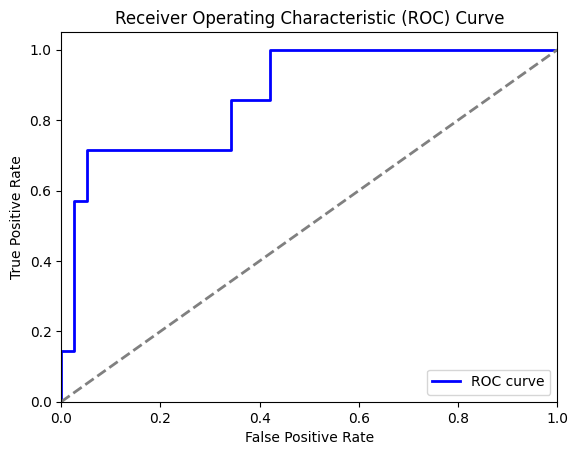

In [19]:
plot_roc_curve(list(pred_msi['Pred_Prob']),list(pred_msi['Y_True']))

In [ ]:
# #PLOT:
# pred_df = all_perd_df
# SELECTED_LABEL = ['MSI_POS']
# #Get True Postives
# true_postive_ids = {}
# for label in SELECTED_LABEL:
#     cond = (pred_df['Y_True'] == pred_df['Pred_Class']) & (pred_df['Y_True'] == 1) & (pred_df['OUTCOME'] == label)
#     cur_pred_df = pred_df.loc[cond]
#     cur_ids = list(cur_pred_df['SAMPLE_IDs'])
#     true_postive_ids[label] = cur_ids

# #Get true nagative
# true_negative_ids = {}
# for label in SELECTED_LABEL:
#     cond = (pred_df['Y_True'] == pred_df['Pred_Class']) & (pred_df['Y_True'] == 0) & (pred_df['OUTCOME'] == label)
#     cur_pred_df = pred_df.loc[cond]
#     cur_ids = list(cur_pred_df['SAMPLE_IDs'])
#     true_negative_ids[label] = cur_ids

In [ ]:
# ####################################################################################
# #Atention scores
# ####################################################################################
# save_image_size = 250
# pixel_overlap = 0
# mag_extract = 20
# limit_bounds = True
# TOP_K = 5
# pretrain_model_name = "retccl"
# mag_target_prob = 2.5
# smooth = True
# mag_target_tiss = 1.25

# def get_attention_and_tileinfo(pt_label_df, patient_att_score):    
#     #Get label
#     pt_label_df.reset_index(drop = True, inplace = True)

#     #Get attention
#     cur_att  = pd.DataFrame({'ATT':list(minmax_normalize(patient_att_score))})
#     cur_att.reset_index(drop = True, inplace = True)

#     #Comb
#     cur_att_df = pd.concat([pt_label_df,cur_att], axis = 1)
#     cur_att_df.reset_index(drop = True, inplace = True)

#     return cur_att_df

In [ ]:
# attn[label_index].shape

In [ ]:
# selected_ids = true_postive_ids[SELECTED_LABEL[0]]
# wsi_path = proj_dir + '/data/OPX/'
# branches = 1

# for pt in selected_ids:
#     i = test_ids.index(pt)
#     pt = test_ids[i]
#     print(pt)

#     save_location = outdir4 + SELECTED_LABEL[0] + "/"
#     save_location =  save_location  + pt + "/"
#     create_dir_if_not_exists(save_location)
    
#     _file = wsi_path + pt + ".tif"
#     oslide = openslide.OpenSlide(_file)
#     save_name = str(Path(os.path.basename(_file)).with_suffix(''))
    
#     first_batch = list(test_loader)[i]
#     feat = first_batch[0].to(device)
#     sub_preds, slide_preds, attn = model(feat)
#     #cur_pt_att =  attn[0,:,:].mean(0).cpu().detach().numpy() #Take the mean across branches without softmax
#     label_index = ALL_LABELS.index(SELECTED_LABEL[0])
#     cur_pt_att = attn[label_index][branches].mean(0).cpu().detach().numpy()
#     #branches = 0
#     #cur_pt_att = torch.softmax(attn, dim=-1)[0][branches].cpu().detach().numpy() 
    
#     #Get all tile info include noncancer tile
#     alltileinfo_dir = proj_dir + 'intermediate_data/TODELETE_cancer_prediction_results110224/' + "IMSIZE250_OL0" + "/"
#     tile_info_df = pd.read_csv(alltileinfo_dir + pt + "/"  + save_name + "_tiles.csv")
#     cur_pt_info = test_info[i]
#     #Combine current pt_info an all tile info
#     #cur_pt_info = tile_info_df.merge(cur_pt_info, on = list(tile_info_df.columns), how = "left")
    
#     cur_att_df = get_attention_and_tileinfo(cur_pt_info, cur_pt_att)
#     #cur_att_df.loc[pd.isna(cur_att_df['ATT']),'ATT'] = 0.0001
    
#     #Generate tiles
#     tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)
    
#     #get level 0 size in px
#     l0_w = oslide.level_dimensions[0][0]
#     l0_h = oslide.level_dimensions[0][1]
    
#     #1.25x tissue detection for mask
#     from Utils import get_downsample_factor, get_image_at_target_mag
#     from Utils import do_mask_original,check_tissue,whitespace_check
#     import cv2
#     if 'OPX' in pt:
#         rad_tissue = 5
#     elif '(2017-0133)' in pt:
#         rad_tissue = 2
#     lvl_resize_tissue = get_downsample_factor(base_mag,target_magnification = mag_target_tiss) #downsample factor
#     lvl_img = get_image_at_target_mag(oslide,l0_w, l0_h,lvl_resize_tissue)
#     tissue, he_mask = do_mask_original(lvl_img, lvl_resize_tissue, rad = rad_tissue)
    
#     #2.5x for probability maps
#     lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
#     x_map = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
#     x_count = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
    
    
#     for index, row in cur_att_df.iterrows():
#         cur_xy = row['TILE_XY_INDEXES'].strip("()").split(", ")
#         x ,y = int(cur_xy[0]) , int(cur_xy[1])
        
#         #Extract tile for prediction
#         lvl_in_deepzoom = tile_lvls.index(mag_extract)
#         tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #get tile coords
#         map_xstart, map_xend, map_ystart, map_yend = get_map_startend(tile_starts,tile_ends,lvl_resize) #Get current tile position in map
    
#         #Store predicted probabily in map and count
#         try: 
#             x_count[map_xstart:map_xend,map_ystart:map_yend] += 1
#             x_map[map_xstart:map_xend,map_ystart:map_yend] += row['ATT']
#         except:
#             pass
    
#     print('post-processing')
#     x_count = np.where(x_count < 1, 1, x_count)
#     x_map = x_map / x_count
#     x_map[x_map>1]=1
    
#     #Get the following before smooth
#     he_mask = cv2.resize(np.uint8(he_mask),(x_map.shape[1],x_map.shape[0])) #resize to output image size
#     cond1 = he_mask < 1 #Background
#     cond2 = (he_mask == 1) & (x_map == 0) #is tissue, but not selected
#     smooth = True
    
#     if smooth == True:
#         #x_sm = filters.gaussian(x_map, sigma=0)
#         x_sm = np.where(x_map != 0, filters.gaussian(x_map, sigma=10), x_map)
#     if smooth == False:
#         x_sm = x_map
    
#     #TODO:
#     #get cancer_mask:
#     # cancer_mask == 
#     # x_sm[(he_mask == 1) & (x_sm == 0)] = 0.1 #If tissue map value > 1, then x_sm = 1
#     x_sm[cond1] = 0 #Background
#     x_sm[cond2] = 0.1 #Is tissue, but not selected 
    
#     # Define the colors for the sequential colormap (black to fluorescent green)
#     colors = ["#4B0082", "#39FF14"]  # Black to Fluorescent Green
#     # Create the sequential colormap
#     cmap_name = "black_to_fluorescent_green"
#     from matplotlib.colors import LinearSegmentedColormap
#     from matplotlib.colors import ListedColormap
#     sequential_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
#     cmap =  plt.cm.Spectral_r #sequential_cmap # plt.cm.YlGn_r
#     cmap_colors = cmap(np.arange(cmap.N))
#     cmap_colors[0] = np.array([0.95, 0.95, 0.95, 1]) #np.array([1, 1, 1, 1])  # Set the first color (corresponding to 0) to white
#     cmap_colors[1] = np.array([0, 0, 0.545, 1])  # RGB for dark blue
#     custom_cmap = ListedColormap(cmap_colors)
    
#     plt.imshow(x_sm, cmap=custom_cmap) #Spectral_r
#     plt.colorbar()
#     plt.savefig(os.path.join(save_location, save_name + '_attention.png'), dpi=500,bbox_inches='tight')
#     plt.show()
#     plt.close()


#     #Top attented tiles
#     save_location2 = save_location + "top_tiles/"
#     create_dir_if_not_exists(save_location2)
    
#     #Get a Attention, and corresponding tiles
#     cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = False) 
#     cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
            
#     for i in range(TOP_K):
#         cur_pulled_img = cur_pulled_img_obj[i][0] #image
#         cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
#         cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
#         coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
#         tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
#         cur_pulled_img.save(os.path.join(save_location2, tile_save_name))
    
#     #Bot attented tiles
#     save_location2 = save_location + "bot_tiles/"
#     create_dir_if_not_exists(save_location2)
    
#     #Get a Attention, and corresponding tiles
#     cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = True) 
#     cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
    
#     for i in range(TOP_K):
#         cur_pulled_img = cur_pulled_img_obj[i][0] #image
#         cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
#         cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
#         coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
#         tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
#         cur_pulled_img.save(os.path.join(save_location2, tile_save_name))

In [ ]:
##############################################################################################################################
# TMA
##############################################################################################################################
y_pred_tasks_test, y_predprob_task_test, y_true_task_test = predict(model, tma_loader, device, conf, 'TMA')
pred_df_list = []
perf_df_list = []
for i in range(conf.n_task):
    if i not in [1,5,6]:
        pred_df, perf_df = get_performance(y_predprob_task_test[i], y_true_task_test[i], tma_ids, ALL_LABELS[i],thres_quantile = 0.7)
        pred_df_list.append(pred_df)
        perf_df_list.append(perf_df)

all_perd_df = pd.concat(pred_df_list)
all_perf_df = pd.concat(perf_df_list)
print(all_perf_df)
all_perd_df.to_csv(outdir4 + "/n_token" + str(conf.n_token) + "_TMA_pred_df.csv",index = False)
all_perf_df.to_csv(outdir5 + "/n_token" + str(conf.n_token) + "_TMA_perf.csv",index = True)
print(round(all_perf_df['AUC'].mean(),2))

In [ ]:
##############################################################################################################################
# TCGA
##############################################################################################################################
y_pred_tasks_test, y_predprob_task_test, y_true_task_test = predict(model, tcga_loader, device, conf, 'TCGA')
pred_df_list = []
perf_df_list = []
for i in range(conf.n_task):
    if i != 5 :
        pred_df, perf_df = get_performance(y_predprob_task_test[i], y_true_task_test[i], tcga_ids, ALL_LABELS[i], thres_quantile = 0.6)
        pred_df_list.append(pred_df)
        perf_df_list.append(perf_df)

all_perd_df = pd.concat(pred_df_list)
all_perf_df = pd.concat(perf_df_list)
print(all_perf_df)
all_perd_df.to_csv(outdir4 + "/n_token" + str(conf.n_token) + "_TCGA_pred_df.csv",index = False)
all_perf_df.to_csv(outdir5 + "/n_token" + str(conf.n_token) + "_TCGA_perf.csv",index = True)
print(round(all_perf_df['AUC'].mean(),2))

In [ ]:
#PLOT:
pred_df = all_perd_df
SELECTED_LABEL = ['MSI_POS']
#Get True Postives
true_postive_ids = {}
for label in SELECTED_LABEL:
    cond = (pred_df['Y_True'] == pred_df['Pred_Class']) & (pred_df['Y_True'] == 1) & (pred_df['OUTCOME'] == label)
    cur_pred_df = pred_df.loc[cond]
    cur_ids = list(cur_pred_df['SAMPLE_IDs'])
    true_postive_ids[label] = cur_ids

#Get true nagative
true_negative_ids = {}
for label in SELECTED_LABEL:
    cond = (pred_df['Y_True'] == pred_df['Pred_Class']) & (pred_df['Y_True'] == 0) & (pred_df['OUTCOME'] == label)
    cur_pred_df = pred_df.loc[cond]
    cur_ids = list(cur_pred_df['SAMPLE_IDs'])
    true_negative_ids[label] = cur_ids

In [ ]:
####################################################################################
#Atention scores
####################################################################################
save_image_size = 250
pixel_overlap = 0
mag_extract = 20
limit_bounds = True
TOP_K = 5
pretrain_model_name = "retccl"
mag_target_prob = 2.5
smooth = True
mag_target_tiss = 1.25

def get_attention_and_tileinfo(pt_label_df, patient_att_score):    
    #Get label
    pt_label_df.reset_index(drop = True, inplace = True)

    #Get attention
    cur_att  = pd.DataFrame({'ATT':list(minmax_normalize(patient_att_score))})
    cur_att.reset_index(drop = True, inplace = True)

    #Comb
    cur_att_df = pd.concat([pt_label_df,cur_att], axis = 1)
    cur_att_df.reset_index(drop = True, inplace = True)

    return cur_att_df

In [ ]:
#print(attn[label_index].shape)

In [ ]:
selected_ids = true_postive_ids[SELECTED_LABEL[0]]
wsi_path = proj_dir + '/data/TCGA_PRAD/'
branches = 0

for pt in selected_ids:
    i = tcga_ids.index(pt)
    pt = tcga_ids[i]
    print(pt)

    save_location = outdir4 + SELECTED_LABEL[0] + "/"
    save_location =  save_location  + pt + "/"
    create_dir_if_not_exists(save_location)

    slides_name = [f for f in os.listdir(wsi_path + pt + '/') if '.svs' in f][0].replace('.svs','')
    _file = wsi_path + pt + '/' + slides_name + '.svs'
    oslide = openslide.OpenSlide(_file)
    save_name = str(Path(os.path.basename(_file)).with_suffix(''))
    
    first_batch = list(tcga_loader)[i]
    feat = first_batch[0].to(device)
    sub_preds, slide_preds, attn = model(feat)
    label_index = ALL_LABELS.index(SELECTED_LABEL[0])
    #cur_pt_att = attn[label_index][:,:,:].mean(1).cpu().detach().numpy() #mean across all branchs
    cur_pt_att = attn[label_index][:,branches,:].mean(0).cpu().detach().numpy()
    #branches = 0
    #cur_pt_att = torch.softmax(attn[label_index], dim=1).cpu().detach().numpy() 
    
    #Get all tile info include noncancer tile    
    alltileinfo_dir = proj_dir + 'intermediate_data/1_tile_pulling/TCGA_PRAD/' + "IMSIZE250_OL0" + "/"
    tile_info_df = pd.read_csv(alltileinfo_dir + pt + "/"  + save_name + "_tiles.csv")
    cur_pt_info = tcga_info[i]
    #Combine current pt_info an all tile info
    #cur_pt_info = tile_info_df.merge(cur_pt_info, on = list(tile_info_df.columns), how = "left")
    
    cur_att_df = get_attention_and_tileinfo(cur_pt_info, cur_pt_att)
    #cur_att_df.loc[pd.isna(cur_att_df['ATT']),'ATT'] = 0.0001
    
    #Generate tiles
    tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)
    
    #get level 0 size in px
    l0_w = oslide.level_dimensions[0][0]
    l0_h = oslide.level_dimensions[0][1]
    
    #1.25x tissue detection for mask
    from Utils import get_downsample_factor, get_image_at_target_mag
    from Utils import do_mask_original,check_tissue,whitespace_check
    import cv2
    if 'OPX' in pt:
        rad_tissue = 5
    elif '(2017-0133)' in pt:
        rad_tissue = 2
    else:
        rad_tissue = 2
    lvl_resize_tissue = get_downsample_factor(base_mag,target_magnification = mag_target_tiss) #downsample factor
    lvl_img = get_image_at_target_mag(oslide,l0_w, l0_h,lvl_resize_tissue)
    tissue, he_mask = do_mask_original(lvl_img, lvl_resize_tissue, rad = rad_tissue)
    
    #2.5x for probability maps
    lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
    x_map = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
    x_count = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
    
    
    for index, row in cur_att_df.iterrows():
        cur_xy = row['TILE_XY_INDEXES'].strip("()").split(", ")
        x ,y = int(cur_xy[0]) , int(cur_xy[1])
        
        #Extract tile for prediction
        lvl_in_deepzoom = tile_lvls.index(mag_extract)
        tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #get tile coords
        map_xstart, map_xend, map_ystart, map_yend = get_map_startend(tile_starts,tile_ends,lvl_resize) #Get current tile position in map
    
        #Store predicted probabily in map and count
        try: 
            x_count[map_xstart:map_xend,map_ystart:map_yend] += 1
            x_map[map_xstart:map_xend,map_ystart:map_yend] += row['ATT']
        except:
            pass
    
    print('post-processing')
    x_count = np.where(x_count < 1, 1, x_count)
    x_map = x_map / x_count
    x_map[x_map>1]=1
    
    #Get the following before smooth
    he_mask = cv2.resize(np.uint8(he_mask),(x_map.shape[1],x_map.shape[0])) #resize to output image size
    cond1 = he_mask < 1 #Background
    cond2 = (he_mask == 1) & (x_map == 0) #is tissue, but not selected
    smooth = True
    
    if smooth == True:
        #x_sm = filters.gaussian(x_map, sigma=0)
        x_sm = np.where(x_map != 0, filters.gaussian(x_map, sigma=10), x_map)
    if smooth == False:
        x_sm = x_map
    
    #TODO:
    #get cancer_mask:
    # cancer_mask == 
    # x_sm[(he_mask == 1) & (x_sm == 0)] = 0.1 #If tissue map value > 1, then x_sm = 1
    x_sm[cond1] = 0 #Background
    x_sm[cond2] = 0.1 #Is tissue, but not selected 
    
    # Define the colors for the sequential colormap (black to fluorescent green)
    colors = ["#4B0082", "#39FF14"]  # Black to Fluorescent Green
    # Create the sequential colormap
    cmap_name = "black_to_fluorescent_green"
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import ListedColormap
    sequential_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
    cmap =  plt.cm.Spectral_r #sequential_cmap # plt.cm.YlGn_r
    cmap_colors = cmap(np.arange(cmap.N))
    cmap_colors[0] = np.array([0.95, 0.95, 0.95, 1]) #np.array([1, 1, 1, 1])  # Set the first color (corresponding to 0) to white
    cmap_colors[1] = np.array([0, 0, 0.545, 1])  # RGB for dark blue
    custom_cmap = ListedColormap(cmap_colors)
    
    plt.imshow(x_sm, cmap=custom_cmap) #Spectral_r
    plt.colorbar()
    plt.savefig(os.path.join(save_location, save_name + '_attention.png'), dpi=500,bbox_inches='tight')
    plt.show()
    plt.close()


    #Top attented tiles
    save_location2 = save_location + "top_tiles/"
    create_dir_if_not_exists(save_location2)
    
    #Get a Attention, and corresponding tiles
    cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = False) 
    cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
            
    for i in range(TOP_K):
        cur_pulled_img = cur_pulled_img_obj[i][0] #image
        cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
        cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
        coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
        tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
        cur_pulled_img.save(os.path.join(save_location2, tile_save_name))
    
    #Bot attented tiles
    save_location2 = save_location + "bot_tiles/"
    create_dir_if_not_exists(save_location2)
    
    #Get a Attention, and corresponding tiles
    cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = True) 
    cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
    
    for i in range(TOP_K):
        cur_pulled_img = cur_pulled_img_obj[i][0] #image
        cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
        cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
        coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
        tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
        cur_pulled_img.save(os.path.join(save_location2, tile_save_name))